In [1]:
### Load necessary libraries ###
import glob
import os
import sys
import logging

import librosa
import librosa.display

import numpy as np
from numpy import size

import matplotlib.pyplot as plt
from matplotlib.pyplot import text, legend

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift

import tensorflow as tf
from tensorflow import keras

from IPython.display import Audio

# Defs: Global Configuration variables

In [2]:
# Debug and test variables
# Do not process all the sound in the dataset (for faster execution during script development)
REDUCED_MODE = 1
# Number of dataset sounds per folder to process in the reduced-mode.
REDUCED_MODE_SOUNDNUM = 50

# sound processing variables
SOUND_SR = 44100  # sound sampling in Hertz
SOUND_F_FFT = 2048  # Samples per FFT window
SOUND_HOP_LEN = 512 # Hop Length
SOUND_N_MELS = 25 # Number of mel frequencies to analyze

SOUNDSEG_SIZE = 41  # windows per subsound / segment
SOUNDSEG_OVERLAP = 0.4  # 40% overlapping factor for engine sounds

SOUNDSEG_OVERSAMPLING = 4  # how many times to increase the engine category samples
SOUNDSEG_CLASS2OVERSAMPLE = 5  # Oversample the engine class (num. 5)

# Preprocessing
PREPROC_SKIP = 1  # Skip preprocessing files and use previosuly saved '.npz'

# CNN Processing
CNN_EPOCHS = 10
CNN_LEAKYRELU = 1
CNN_BATCHSIZE = 32
CNN_KERNELSIZE = (3,3)
CNN_POOLSIZE = (2,2)

# Paths and folders
soundsPath = 'UrbanSounds8K/1_audioFiles/'
soundsSubPaths = np.array(['fold1', 'fold2', 'fold3', 'fold4',
                          'fold5', 'fold6', 'fold7', 'fold8', 'fold9', 'fold10'])
preProcPath = "UrbanSounds8K/2_featuresProcessed/"
trainingResultsPath = "UrbanSounds8K/3_trainingResults/"
logPath = "UrbanSounds8k/4_executionLog/"

confusionFile = "confusion_matrix"
trainingFile = "trainingResults"

# Defs: Data displaying and logging to file

In [3]:
# Setup logging both in console and file
if not 'procLog' in vars():
    sHand = logging.StreamHandler();
    procLog = logging.getLogger('PreProc')
    logging.basicConfig(level = logging.INFO,
     filename = logPath + 'executionLog.log',
      filemode = 'w', format = '%(asctime)s :: %(message)s',
      datefmt='%d-%b-%y %H:%M:%S');
    procLog.addHandler(sHand);


# Defs: Preprocessing and feature extraction from audios

In [4]:
# Divide an sound file into shorter and overlapped parts.
def soundSegmentation(soundSignal, subsoundSize, overlapFactor=SOUNDSEG_OVERLAP):
    start = 0
    while start < len(soundSignal):
        yield int(start), int(start + subsoundSize)
        start += (subsoundSize // (1/(1-overlapFactor)))

# Add white noise to signal respecting a maximum amplitude based on RMS energy of the original signal
def soundAddGaussianNoise(soundSignal, sampleRate = SOUND_SR, maxAmplitude_percRMS = 0.1):
    signalRMS = (np.average(soundSignal**2))**(1/2);
    
    randomFact1 = np.random.rand(1);
    randomFact2 = np.random.rand(1);

    factMax =  signalRMS * maxAmplitude_percRMS * (randomFact1 if randomFact1 > randomFact2 else randomFact2);
    factMin =  signalRMS * maxAmplitude_percRMS * (randomFact1 if randomFact1 < randomFact2 else randomFact2);

    transform = AddGaussianNoise(min_amplitude=factMin, max_amplitude=factMax,p=1);
    augSoundSignal = transform(soundSignal,sample_rate=44100);

    return augSoundSignal

# Load sound with Librosa and make it faster or slower (time stretching)
def soundLoadAndStretch(soundPath, sampleRate = SOUND_SR, maxStretch = 0.1):
    randomFact = (np.random.rand(1) - 0.5) * maxStretch;
    soundSignal, sr = librosa.load(soundPath, sr=SOUND_SR * (1+maxStretch));
    return soundSignal;

In [5]:
# Extract features from sound files, generating spectogram segments (images)
def extractSoundFeature(soundsPath, soundsSubPath, n_mels=SOUND_N_MELS, n_windows=SOUNDSEG_SIZE, hopLength=SOUND_HOP_LEN,
                        soundOversamplingFact=SOUNDSEG_OVERSAMPLING, soundOverClass=SOUNDSEG_CLASS2OVERSAMPLE):

    subsoundSize = hopLength * (n_windows - 1)
    features_AM, origClasses_A, segSounds_AA = [], [], []

    # Map all sound samples paths inside the folder
    allsoundsPath_A = glob.glob(os.path.join(
        soundsPath, soundsSubPath, "*.wav"))

    # Iterate and extract features from each sound
    idxSound, idxSegment = 0, 0
    for soundPath in allsoundsPath_A:
        idxSound = idxSound+1
        # Early stop for reduced mode
        if REDUCED_MODE == 1 and idxSound == REDUCED_MODE_SOUNDNUM:
            break

        # Extract sound class by parsing file name
        soundClass = int(soundPath.split('/')[2].split('-')[1])

        # Loop more than once in the same sound (oversampling) if is engine class (5)
        if soundClass == soundOverClass:
            maxRepeatOverSampl = soundOversamplingFact  # Oversampling by repetition
            overlapFactor = SOUNDSEG_OVERLAP  # Oversampling by overlapping
        else:
            maxRepeatOverSampl = 1
            overlapFactor = 0

        idxOverSampl = 0
        for idxOverSampl in np.arange(maxRepeatOverSampl):

            # Extract '.wav' sound to an 1-D array and apply stretching if required
            if idxOverSampl > 0:
                soungSignal_A = soundLoadAndStretch(
                    soundPath, SOUND_SR, 0.1)  # stretch
            else:
                soungSignal_A = soundLoadAndStretch(
                    soundPath, SOUND_SR, 0.0)  # don't stretch

            # Create subsegments from sound file and extract the features
            segSoundSignal_AA, segSoundSpect_AM, segSoundClass_A = [], [], []  # Init arrays
            for (start, end) in soundSegmentation(soungSignal_A, subsoundSize, overlapFactor):
                if (len(soungSignal_A[start:end]) == subsoundSize):
                    idxSegment = idxSegment+1

                    # Append sound class to segments class array
                    segSoundClass_A.append(soundClass)

                    # Extract segment from sound data - 1D Array
                    segSoundSignal_A = soungSignal_A[start:end]
                    segSoundSignal_AA.append(segSoundSignal_A)  # All segs. array

                    # Apply data augmentation if repeated loop
                    if idxOverSampl > 0:
                        segSoundSignal_A = soundAddGaussianNoise(segSoundSignal_A, SOUND_SR, 0.1)

                    # Transform to spectogram in decibels - 2D Matrix
                    segsoundSpect_M = librosa.feature.mfcc(y=segSoundSignal_A, n_mfcc=n_mels)
                    #segsoundSpect_M = librosa.feature.melspectrogram(y=segSoundSignal_A, n_mels=n_mels)
                    #segsoundSpect_M = librosa.amplitude_to_db(segsoundSpect_M)

                    # Reshape and append to preprocessed spectograms
                    segsoundSpect_M = segsoundSpect_M.T.flatten()[:, np.newaxis].T
                    segSoundSpect_AM.append(segsoundSpect_M)

            segSoundSpect_AM = np.asarray(segSoundSpect_AM).reshape(len(segSoundSpect_AM), n_mels, n_windows, 1)

            # If last sound not empty, stack together with others
            if len(segSoundSpect_AM) > 0:
                segSounds_AA.append(segSoundSignal_AA)
                features_AM.append(segSoundSpect_AM)
                origClasses_A.append(segSoundClass_A)
    
    procLog.log(msg = '-> Num of segments for '+ soundsSubPath +' -> ' + str(idxSegment) + 
                ' - out of - ' + str(idxSound) + ' sounds.', level=20)

    # Stack all data 'per segment' and not 'per sound'
    segSounds_AA = np.concatenate(segSounds_AA, axis=0)
    features_AM = np.concatenate(features_AM, axis=0)
    origClasses_A = np.concatenate(origClasses_A, axis=0)

    # Convert UrbanSounds8K class to binary 'is/isn't engine'
    engineClasses_A = np.array(
        list(map(lambda x: 1 if x == 5 else 0, origClasses_A)))

    return segSounds_AA, features_AM, engineClasses_A


# Defs: CNN Model

In [6]:
# Define convolutional network architecture ###
def CNN_modelDefinition(useLeakyRelu=0):
    keras.backend.clear_session()

    pool_size = CNN_POOLSIZE
    kernel_size = CNN_KERNELSIZE
    input_shape = (SOUND_N_MELS, SOUNDSEG_SIZE, 1)
    num_classes = 2  

    # ---------- Convolutional + Pooling Layer 1 ---------- #
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(80, kernel_size, padding="same",
              input_shape=input_shape, dilation_rate=1))
    model.add(keras.layers.BatchNormalization())
    if useLeakyRelu == 0:
        model.add(keras.layers.Activation("relu"))
    else:
        model.add(keras.layers.LeakyReLU(alpha=0.1))
    model.add(keras.layers.MaxPooling2D(pool_size=pool_size))

    model.add(keras.layers.Dropout(0.2))

    # ---------- Convolutional + Pooling Layer 2 ---------- #
    model.add(keras.layers.Conv2D(80, kernel_size,
              padding="same", dilation_rate=2))
    model.add(keras.layers.BatchNormalization())
    if useLeakyRelu == 0:
        model.add(keras.layers.Activation("relu"))
    else:
        model.add(keras.layers.LeakyReLU(alpha=0.1))
    model.add(keras.layers.MaxPooling2D(pool_size=pool_size))

    model.add(keras.layers.Dropout(0.2))

    # ---------- Pooling Layer Layer ---------- #
    model.add(keras.layers.GlobalMaxPooling2D())

    # ---------- Flat Layers ---------- #
    model.add(keras.layers.Dense(512, activation="relu"))
    model.add(keras.layers.Dense(num_classes, activation="softmax"))

    model.compile(optimizer=keras.optimizers.Adam(1e-4), loss=keras.losses.SparseCategoricalCrossentropy(),
                  metrics=["accuracy"])
    return model


# Proc: Sound Processing and Features Extraction

In [7]:
# Pre-process and extract feature from the data
if PREPROC_SKIP == 0:
    fig, axes = plt.subplots(2, 5, dpi=120)
    axes = axes.ravel()
    fig.set_figheight(10*0.5)
    fig.set_figwidth(25*0.5)
    fig.tight_layout(pad=4.5)

    # Loop through all sound folders
    idxFold = 0
    for soundSubPath in soundsSubPaths:
        # Extract files from folder and save externally for reuse
        segSounds_AA, features_AM, classes_A = extractSoundFeature(soundsPath, soundSubPath)
        np.savez("{0}{1}".format(preProcPath, soundSubPath),
                 segSounds = segSounds_AA, features=features_AM, classes=classes_A)

        # Plot histogram of data balancing per folder
        axes[idxFold].set_title('Folder ' + str(idxFold+1) + ' balancing')
        tmpData = np.asarray(classes_A)
        tmpData = [np.count_nonzero(tmpData == 0),
                   np.count_nonzero(tmpData == 1)]
        axes[idxFold].bar(['Not Eng.', 'Eng.'], tmpData,
                          align='edge', width=-0.4, label="Train")
        idxFold += 1
    fig.savefig(fname = logPath + '1_foldersProcessing.jpg' );
        

# Proc:  CNN Training and Testing

In [8]:
### Train and evaluate via 10-soundsSubPaths cross-validation ###
kf = KFold(n_splits=10)

# List containing all confusion matrix for all K-Fold Train-Test.
# Array containing the results of the training for each train/test set.
allConfusionMatrix_AM, allFitResults_A, allCNNModels_A = [], [], []
bestConfusionMatrix_AM, bestCNNModels_A = [], []

# Loop to train-test in all folder combinations.
idx = 0
for train_index, test_index in kf.split(soundsSubPaths):
    idx = idx+1
    procLog.info('----------> PROC: Starting a loop! - Folder ' + str(idx)+ ' <----------');
    x_train, y_train = [], []

    # ---------------- STEP 1 ----------------
    # Load training data from 9 out of 10 folders
    # Loop through all training folders and gather data in single feature array
    for idxTrainFolder in train_index:
        procLog.info('-> Getting data from TRAINING folder ' +  str(idxTrainFolder+1))
        # Read pre-saved features or segments of an sound file (pre-processed)
        train_data = np.load("{0}/{1}.npz".format(preProcPath, soundsSubPaths[idxTrainFolder]), allow_pickle=True);

        # Append all the 'features/classes' train datasets in a single list (all folders)
        x_train.append(train_data["features"]);
        y_train.append(train_data["classes"]);

    # Stack all the folders in a single X/Y dataset
    x_train = np.concatenate(x_train, axis=0).astype(np.float32);
    y_train = np.concatenate(y_train, axis=0).astype(np.float32);
    procLog.info('-> TRAIN dataset size: ' + str(len(x_train)))

    # ---------------- STEP 2 ----------------
    # Load test data from 1 out of 10 folders
    procLog.info('-> Getting data from TESTING folder ' + str(test_index+1))
    test_data = np.load("{0}/{1}.npz".format(preProcPath, soundsSubPaths[test_index][0]), allow_pickle=True)
    x_test, y_test = test_data["features"], test_data["classes"];
    procLog.info('-> TEST dataset size: ' + str(len(x_test)))

    # Load and fit the CNN Model
    procLog.info('-> Fitting model!');
    CNN_model = CNN_modelDefinition(useLeakyRelu=CNN_LEAKYRELU);

    earlyStopCB = keras.callbacks.EarlyStopping(monitor='loss', patience=3,min_delta=0, verbose=1, restore_best_weights= True);
    
    mdlCheckPointPath = "{0}{1}{2}".format(trainingResultsPath, 'CNN_bestWeights_', idx)
    mdlCheckpointCB = keras.callbacks.ModelCheckpoint(filepath=mdlCheckPointPath, monitor='val_accuracy', mode='max',  save_best_only=True);
    
    allFitResults_A.append(CNN_model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=CNN_EPOCHS, batch_size=CNN_BATCHSIZE, 
        verbose=1, callbacks = [earlyStopCB,mdlCheckpointCB]));
    allCNNModels_A.append(CNN_model); # Append complete CNN model for testing afterwards

    # Save model data to log
    procLog.info('-> Accuracy:' + str(allFitResults_A[-1].history["accuracy"][-1]));
    procLog.info('-> Val. Accuracy:' + str(allFitResults_A[-1].history["val_accuracy"][-1]));
    procLog.info('-> Loss:' + str(allFitResults_A[-1].history["loss"][-1]));
    procLog.info('-> Val. Loss:' + str(allFitResults_A[-1].history["val_loss"][-1]));

    # Predict results from test data
    y_test_pred = CNN_model.predict(x_test)  # Categorical results
    y_test_pred = np.asarray(tf.argmax(y_test_pred, axis=1))  # OHE to Category

    # Calculate and append the confusion matrix of this K-Fold run to a matrix list
    allConfusionMatrix_AM.append(confusion_matrix(y_test, y_test_pred, normalize='true'))

    # Get the best model (best epoch) & append it
    bestModel = CNN_model;
    bestModel.load_weights(mdlCheckPointPath);
    bestCNNModels_A.append(bestModel);

    # Predict results from test data in best model
    y_test_pred_best = bestModel.predict(x_test)  # Categorical results
    y_test_pred_best = np.asarray(tf.argmax(y_test_pred_best, axis=1))  # OHE to Category

    # Calculate best confusion matrix
    bestConfusionMatrix_AM.append(confusion_matrix(y_test, y_test_pred_best, normalize='true'))

    # Early break for reduced mode
    if REDUCED_MODE == 1 and idx == 4:
        break

# Save the resulting confusion matrices and training data to file
np.savez("{0}{1}".format(trainingResultsPath, confusionFile), allConfusionMatrix_AM=allConfusionMatrix_AM, bestConfusionMatrix_AM=bestConfusionMatrix_AM);
np.savez("{0}{1}".format(trainingResultsPath, trainingFile), allFitResults_A=allFitResults_A, allCNNModels_A = allCNNModels_A, bestCNNModels_A=bestCNNModels_A);


----------> PROC: Starting a loop! - Folder 1 <----------
-> Getting data from TRAINING folder 2
-> Getting data from TRAINING folder 3
-> Getting data from TRAINING folder 4
-> Getting data from TRAINING folder 5
-> Getting data from TRAINING folder 6
-> Getting data from TRAINING folder 7
-> Getting data from TRAINING folder 8
-> Getting data from TRAINING folder 9
-> Getting data from TRAINING folder 10
-> TRAIN dataset size: 100698
-> Getting data from TESTING folder [1]
-> TEST dataset size: 11065
-> Fitting model!


Epoch 1/10
3147/3147 [==============================] - 163s 52ms/step - loss: 0.3546 - accuracy: 0.8414 - val_loss: 0.7186 - val_accuracy: 0.6826
Epoch 2/10
3147/3147 [==============================] - 163s 52ms/step - loss: 0.2888 - accuracy: 0.8727 - val_loss: 0.7140 - val_accuracy: 0.7286
Epoch 3/10
3147/3147 [==============================] - 164s 52ms/step - loss: 0.2535 - accuracy: 0.8900 - val_loss: 0.7562 - val_accuracy: 0.7505
Epoch 4/10
3147/3147 [==============================] - 172s 55ms/step - loss: 0.2260 - accuracy: 0.9031 - val_loss: 0.7309 - val_accuracy: 0.7697
Epoch 5/10
3147/3147 [==============================] - 166s 53ms/step - loss: 0.2044 - accuracy: 0.9139 - val_loss: 0.7111 - val_accuracy: 0.7746
Epoch 6/10
3147/3147 [==============================] - 168s 53ms/step - loss: 0.1876 - accuracy: 0.9224 - val_loss: 0.6494 - val_accuracy: 0.7759
Epoch 7/10
3147/3147 [==============================] - 169s 54ms/step - loss: 0.1718 - accuracy: 0.9304 - val_loss: 0

-> Accuracy:0.9439710974693298
-> Val. Accuracy:0.7894261479377747
-> Loss:0.141630619764328
-> Val. Loss:0.6645592451095581
----------> PROC: Starting a loop! - Folder 2 <----------
-> Getting data from TRAINING folder 1
-> Getting data from TRAINING folder 3
-> Getting data from TRAINING folder 4
-> Getting data from TRAINING folder 5
-> Getting data from TRAINING folder 6
-> Getting data from TRAINING folder 7
-> Getting data from TRAINING folder 8
-> Getting data from TRAINING folder 9
-> Getting data from TRAINING folder 10
-> TRAIN dataset size: 100546
-> Getting data from TESTING folder [2]
-> TEST dataset size: 11217
-> Fitting model!


Epoch 1/10
3143/3143 [==============================] - 163s 52ms/step - loss: 0.3708 - accuracy: 0.8371 - val_loss: 0.5986 - val_accuracy: 0.7150
Epoch 2/10
3143/3143 [==============================] - 164s 52ms/step - loss: 0.2794 - accuracy: 0.8791 - val_loss: 0.6012 - val_accuracy: 0.6978
Epoch 3/10
3143/3143 [==============================] - 161s 51ms/step - loss: 0.2303 - accuracy: 0.9031 - val_loss: 0.5209 - val_accuracy: 0.7400
Epoch 4/10
3143/3143 [==============================] - 169s 54ms/step - loss: 0.2008 - accuracy: 0.9165 - val_loss: 0.5379 - val_accuracy: 0.7464
Epoch 5/10
3143/3143 [==============================] - 162s 51ms/step - loss: 0.1810 - accuracy: 0.9272 - val_loss: 0.4824 - val_accuracy: 0.7740
Epoch 6/10
3143/3143 [==============================] - 160s 51ms/step - loss: 0.1659 - accuracy: 0.9341 - val_loss: 0.6758 - val_accuracy: 0.7203
Epoch 7/10
3143/3143 [==============================] - 163s 52ms/step - loss: 0.1561 - accuracy: 0.9377 - val_loss: 0

-> Accuracy:0.9503411650657654
-> Val. Accuracy:0.7963805198669434
-> Loss:0.12881354987621307
-> Val. Loss:0.4992818832397461
----------> PROC: Starting a loop! - Folder 3 <----------
-> Getting data from TRAINING folder 1
-> Getting data from TRAINING folder 2
-> Getting data from TRAINING folder 4
-> Getting data from TRAINING folder 5
-> Getting data from TRAINING folder 6
-> Getting data from TRAINING folder 7
-> Getting data from TRAINING folder 8
-> Getting data from TRAINING folder 9
-> Getting data from TRAINING folder 10
-> TRAIN dataset size: 99798
-> Getting data from TESTING folder [3]
-> TEST dataset size: 11965
-> Fitting model!


Epoch 1/10
3119/3119 [==============================] - 168s 54ms/step - loss: 0.3754 - accuracy: 0.8320 - val_loss: 0.6019 - val_accuracy: 0.7081
Epoch 2/10
3119/3119 [==============================] - 160s 51ms/step - loss: 0.2933 - accuracy: 0.8703 - val_loss: 0.6445 - val_accuracy: 0.7081
Epoch 3/10
3119/3119 [==============================] - 161s 52ms/step - loss: 0.2428 - accuracy: 0.8969 - val_loss: 0.5515 - val_accuracy: 0.7712
Epoch 4/10
3119/3119 [==============================] - 161s 52ms/step - loss: 0.2124 - accuracy: 0.9124 - val_loss: 0.5234 - val_accuracy: 0.7948
Epoch 5/10
3119/3119 [==============================] - 162s 52ms/step - loss: 0.1896 - accuracy: 0.9235 - val_loss: 0.5000 - val_accuracy: 0.8224
Epoch 6/10
3119/3119 [==============================] - 162s 52ms/step - loss: 0.1735 - accuracy: 0.9307 - val_loss: 0.5145 - val_accuracy: 0.8257
Epoch 7/10
3119/3119 [==============================] - 160s 51ms/step - loss: 0.1592 - accuracy: 0.9367 - val_loss: 0

-> Accuracy:0.9485761523246765
-> Val. Accuracy:0.8395319581031799
-> Loss:0.13148798048496246
-> Val. Loss:0.5212936997413635
----------> PROC: Starting a loop! - Folder 4 <----------
-> Getting data from TRAINING folder 1
-> Getting data from TRAINING folder 2
-> Getting data from TRAINING folder 3
-> Getting data from TRAINING folder 5
-> Getting data from TRAINING folder 6
-> Getting data from TRAINING folder 7
-> Getting data from TRAINING folder 8
-> Getting data from TRAINING folder 9
-> Getting data from TRAINING folder 10
-> TRAIN dataset size: 99470
-> Getting data from TESTING folder [4]
-> TEST dataset size: 12293
-> Fitting model!


Epoch 1/10
3109/3109 [==============================] - 164s 53ms/step - loss: 0.3747 - accuracy: 0.8330 - val_loss: 0.4088 - val_accuracy: 0.8095
Epoch 2/10
3109/3109 [==============================] - 161s 52ms/step - loss: 0.2888 - accuracy: 0.8728 - val_loss: 0.4180 - val_accuracy: 0.7923
Epoch 3/10
3109/3109 [==============================] - 162s 52ms/step - loss: 0.2355 - accuracy: 0.8992 - val_loss: 0.4303 - val_accuracy: 0.8066
Epoch 4/10
3109/3109 [==============================] - 161s 52ms/step - loss: 0.2042 - accuracy: 0.9156 - val_loss: 0.4202 - val_accuracy: 0.8032
Epoch 5/10
3109/3109 [==============================] - 161s 52ms/step - loss: 0.1845 - accuracy: 0.9251 - val_loss: 0.4719 - val_accuracy: 0.8115
Epoch 6/10
3109/3109 [==============================] - 159s 51ms/step - loss: 0.1700 - accuracy: 0.9318 - val_loss: 0.4764 - val_accuracy: 0.8017
Epoch 7/10
3109/3109 [==============================] - 161s 52ms/step - loss: 0.1596 - accuracy: 0.9366 - val_loss: 0

-> Accuracy:0.9496632218360901
-> Val. Accuracy:0.7563654184341431
-> Loss:0.12996403872966766
-> Val. Loss:0.630919873714447


INFO:tensorflow:Assets written to: ram://2e6783ad-23f8-4b57-a617-c1e2da142606/assets
INFO:tensorflow:Assets written to: ram://d3efc6f2-fc04-4df9-980c-b83daf7b8963/assets
INFO:tensorflow:Assets written to: ram://53fff62d-7783-4504-bf24-67b1f12a0a12/assets
INFO:tensorflow:Assets written to: ram://013bb306-0066-4d96-a01c-604eca01c376/assets
INFO:tensorflow:Assets written to: ram://090cf388-44fb-4941-9780-bdcfc7d29eab/assets
INFO:tensorflow:Assets written to: ram://147cab43-42ca-4243-9000-773e5c718beb/assets
INFO:tensorflow:Assets written to: ram://3103ee71-8ab3-404f-9a7c-4576efa9799f/assets
INFO:tensorflow:Assets written to: ram://fec88f31-f98f-40de-85e5-abe2fee6fff5/assets
INFO:tensorflow:Assets written to: ram://00e5f54c-4693-4c0d-8587-33940ebaec56/assets
INFO:tensorflow:Assets written to: ram://6a329e44-84e0-410f-916a-e432a8ac4dc8/assets
INFO:tensorflow:Assets written to: ram://db3d3599-be1f-4831-a289-b33137792a01/assets
INFO:tensorflow:Assets written to: ram://f5987d4e-5e2c-45fd-a25d-

Class identifiers according to UrbanSounds 8k :

0 = air_conditioner
1 = car_horn
2 = children_playing
3 = dog_bark
4 = drilling
5 = engine_idling
6 = gun_shot
7 = jackhammer
8 = siren
9 = street_music

# Analyze: Plot all the final confusion matrices + final average

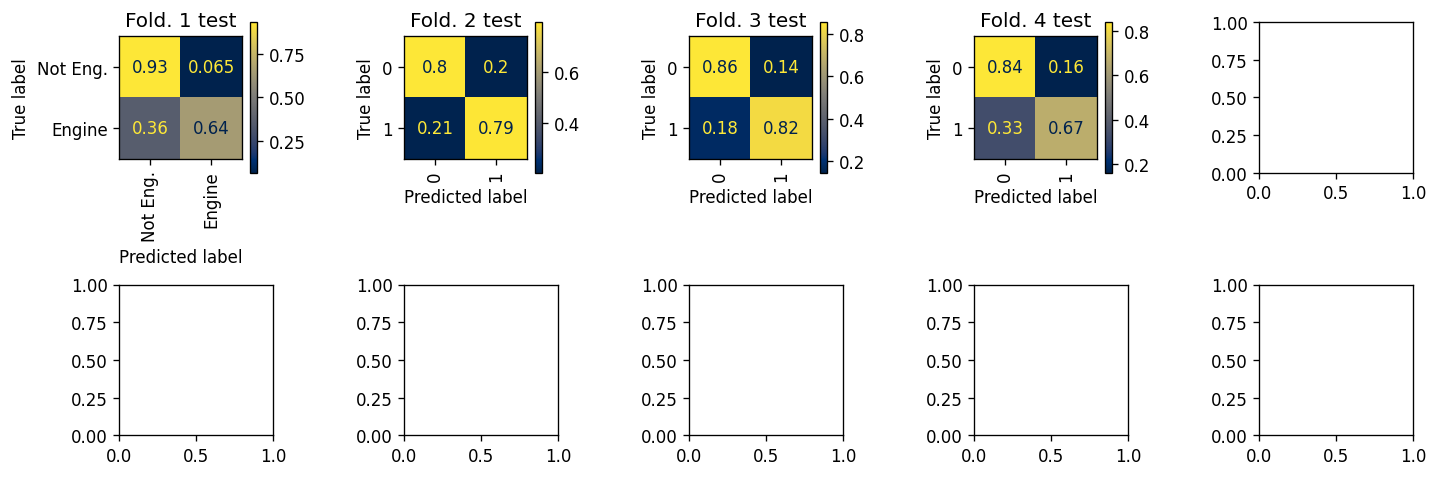

In [9]:
# Load from pre-saved file
allConfusionMatrix_AM = np.load(
    "{0}/{1}.npz".format(trainingResultsPath, confusionFile), allow_pickle=True)["allConfusionMatrix_AM"]

# Plot all confusion matrix
fig, axes = plt.subplots(2, 5, dpi=120)
fig.set_figheight(10*.5); fig.set_figwidth(25*.5); fig.tight_layout(pad=4.5)

idxRow, idxCol = 0, 0
for cm in allConfusionMatrix_AM:
    axes[idxRow][idxCol].set_title('Fold. ' + str(5*idxRow+idxCol+1) + ' test')
    if idxCol == 0:
        cmDisplay = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Eng.', 'Engine'])
    else:
        cmDisplay = ConfusionMatrixDisplay(confusion_matrix=cm)
    cmPlt = cmDisplay.plot(ax=axes[idxRow][idxCol], cmap='cividis', xticks_rotation='vertical');

    idxCol += 1
    if idxCol == 5:
        idxCol, idxRow = 0, 1;
    
    fig.savefig(fname = logPath + '2_allConfusionMatrix.jpg' );

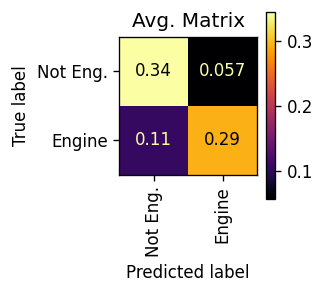

In [10]:
# Average results
confusionMatrixAvg_M = np.zeros([2,2]);
for cm in allConfusionMatrix_AM:
    confusionMatrixAvg_M += cm;
confusionMatrixAvg_M *=0.1;

# Plot
fig, axes = plt.subplots(dpi=120)
fig.set_figheight(2); fig.set_figwidth(2); fig.tight_layout(pad=0.5);

axes.set_title('Avg. Matrix')
cmDisplay = ConfusionMatrixDisplay(confusion_matrix=confusionMatrixAvg_M, display_labels=['Not Eng.', 'Engine'])
cmDisplay.plot(ax=axes,  cmap='inferno', xticks_rotation='vertical')

fig.savefig(fname = logPath + '3_avgConfusionMatrix.jpg' );

# Analyze: Plot the best confusion matrices + best average

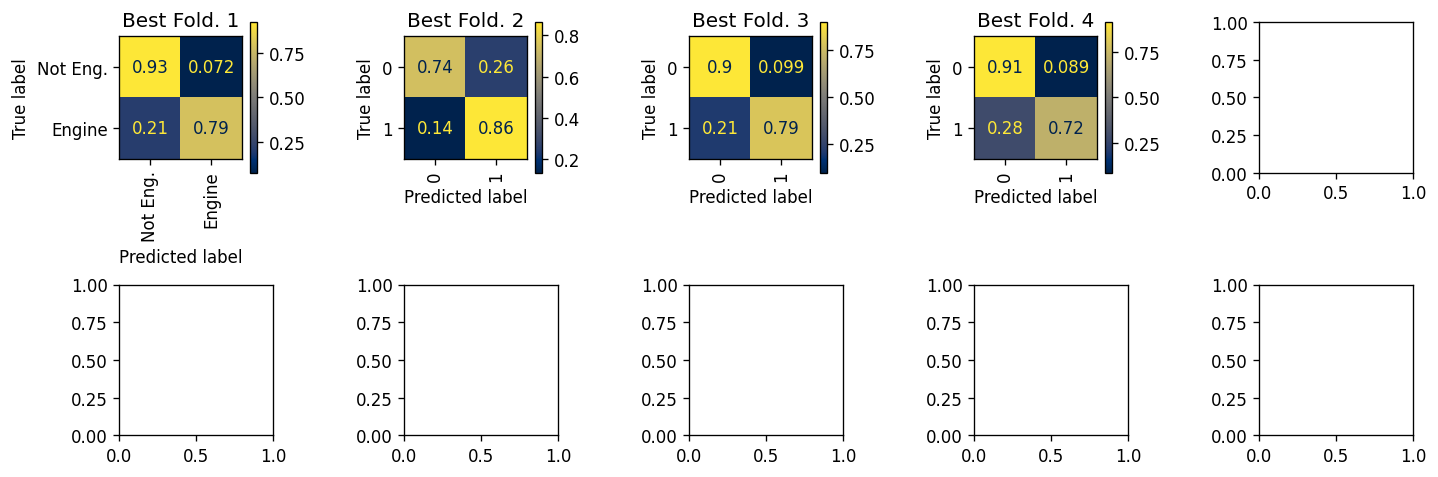

In [27]:
# Load from pre-saved file
bestConfusionMatrix_AM = np.load(
    "{0}/{1}.npz".format(trainingResultsPath, confusionFile), allow_pickle=True)["bestConfusionMatrix_AM"]

# Plot all confusion matrix
fig, axes = plt.subplots(2, 5, dpi=120)
fig.set_figheight(10*.5); fig.set_figwidth(25*.5); fig.tight_layout(pad=4.5)

idxRow, idxCol = 0, 0
for cm in bestConfusionMatrix_AM:
    axes[idxRow][idxCol].set_title('Best Fold. ' + str(5*idxRow+idxCol+1) + '')
    if idxCol == 0:
        cmDisplay = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Eng.', 'Engine'])
    else:
        cmDisplay = ConfusionMatrixDisplay(confusion_matrix=cm)
    cmPlt = cmDisplay.plot(ax=axes[idxRow][idxCol], cmap='cividis', xticks_rotation='vertical');

    idxCol += 1
    if idxCol == 5:
        idxCol, idxRow = 0, 1;
    
    fig.savefig(fname = logPath + '2b_bestConfusionMatrix.jpg' );

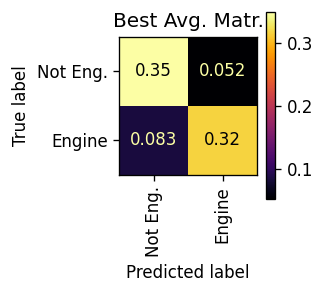

In [25]:
# Average results
bestMatrixAvg_M = np.zeros([2,2]);
for cm in bestConfusionMatrix_AM:
    bestMatrixAvg_M += cm;
bestMatrixAvg_M *=0.1;

# Plot
fig, axes = plt.subplots(dpi=120)
fig.set_figheight(2); fig.set_figwidth(2); fig.tight_layout(pad=0.5);

axes.set_title('Best Avg. Matr.')
cmDisplay = ConfusionMatrixDisplay(confusion_matrix=bestMatrixAvg_M, display_labels=['Not Eng.', 'Engine'])
cmDisplay.plot(ax=axes,  cmap='inferno', xticks_rotation='vertical')

fig.savefig(fname = logPath + '3b_avgConfusionMatrix.jpg' );

# Analyze: Plot training and testing graphs

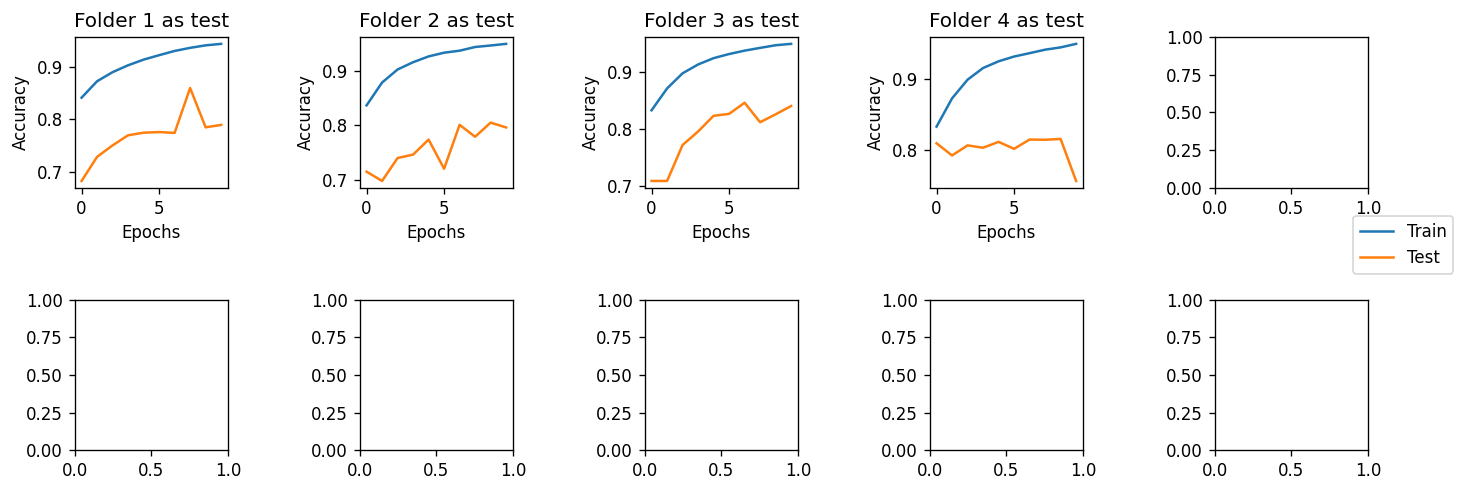

In [13]:
# Plot
fig, axes = plt.subplots(2,5,dpi=120)
fig.set_figheight(10*.5); fig.set_figwidth(25*.5); fig.tight_layout(pad=4.5)

idxRow, idxCol = 0, 0
for resPlot in allFitResults_A:
    axes[idxRow][idxCol].set_title('Folder ' + str(5*idxRow+idxCol+1) + ' as test')
    axes[idxRow][idxCol].plot(resPlot.history['accuracy']); 
    axes[idxRow][idxCol].plot(resPlot.history['val_accuracy']);
    axes[idxRow][idxCol].set(ylabel = 'Accuracy', xlabel= 'Epochs');
    idxCol += 1
    if idxCol == 5:
        idxCol, idxRow = 0, 1;
fig.legend(['Train' , 'Test'], loc=5, bbox_to_anchor=(1, 0.517), fontsize = 'medium');
fig.savefig(fname = logPath + '4_allTrainTestStats.jpg' );


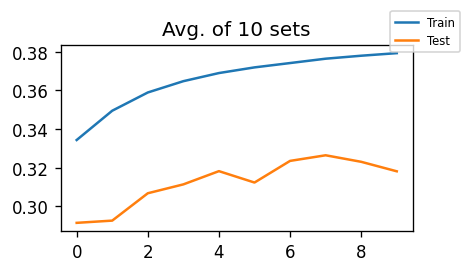

In [14]:
# Average results
avgAcc = np.zeros(np.shape(allFitResults_A[0].history['accuracy']))
avgValAcc = np.zeros(np.shape(allFitResults_A[0].history['val_accuracy']))
for resPlot in allFitResults_A:
    avgAcc += resPlot.history['accuracy'];
    avgValAcc += resPlot.history['val_accuracy'];
avgAcc*=0.1; avgValAcc*=0.1;

#Plot
fig, axes = plt.subplots(dpi=120)
fig.set_figheight(2); fig.set_figwidth(3.5); fig.tight_layout(pad=0.5);

axes.set_title('Avg. of 10 sets')
plt.plot(avgAcc);
plt.plot(avgValAcc);
fig.legend(['Train' , 'Test'], loc=1, bbox_to_anchor=(1.075, 1.1), fontsize = 'x-small');
fig.savefig(fname = logPath + '5_avgTrainTestStats.jpg' );

# Misc: Sound segment analysis

In [15]:
# Find a non-engine sound
for idx in np.arange( len(train_data["classes"])  ):
    if train_data["classes"][idx] == 0:
        print('Found!');
        break;

Audio(train_data["segSounds"][idx], rate=SOUND_SR)

Found!


In [16]:
# Find an engine sound
for idx in np.arange( len(train_data["classes"])  ):
    if train_data["classes"][idx] == 1:
        print('Found!');
        break;

Audio(train_data["segSounds"][idx], rate=SOUND_SR)

Found!


# Plot categories distribution

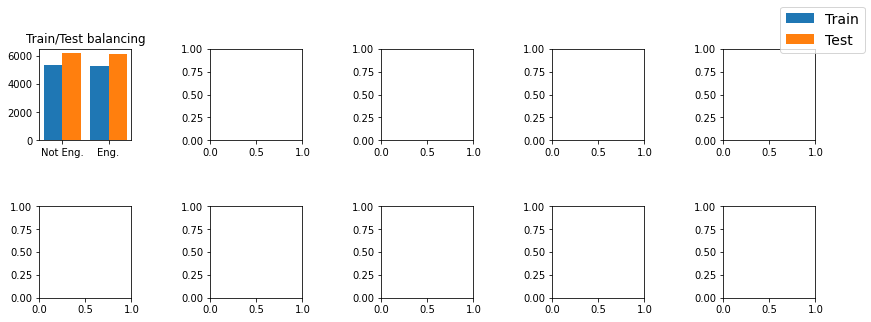

In [17]:
f, a = plt.subplots(2, 5)
a = a.ravel()

f.set_figheight(10*0.5)
f.set_figwidth(25*0.5)
f.tight_layout(pad=4.5)

a[0].set_title('Train/Test balancing')

# Histogram of data per class in train dataset
tmpData = np.asarray(train_data["classes"])
tmpData = [np.count_nonzero(tmpData == 0), np.count_nonzero(tmpData == 1)]
a[0].bar(['Not Eng.', 'Eng.'], tmpData,
         align='edge', width=-0.4, label="Train")

# Histogram of data per class in test dataset
tmpData = np.asarray(test_data["classes"])
tmpData = [np.count_nonzero(tmpData == 0), np.count_nonzero(tmpData == 1)]
a[0].bar(['Not Eng.', 'Eng.'], tmpData, align='edge', width=0.4, label="Test")

f.legend(fontsize=14)


In [18]:
procLog.info(allFitResults_A[-1].history)

{'loss': [0.374688059091568, 0.28882521390914917, 0.23548832535743713, 0.204201802611351, 0.1845092624425888, 0.17003276944160461, 0.1596372127532959, 0.14828930795192719, 0.13971130549907684, 0.12996403872966766], 'accuracy': [0.8329848051071167, 0.8728360533714294, 0.8991655707359314, 0.9156026840209961, 0.9250628352165222, 0.9317885041236877, 0.9365537166595459, 0.9414497017860413, 0.9446969032287598, 0.9496632218360901], 'val_loss': [0.4088321626186371, 0.4179660975933075, 0.43032005429267883, 0.4201682209968567, 0.4718707501888275, 0.4763948321342468, 0.42922067642211914, 0.48389574885368347, 0.5010039806365967, 0.630919873714447], 'val_accuracy': [0.8094850778579712, 0.7923208475112915, 0.8065565824508667, 0.8032213449478149, 0.8115187287330627, 0.8016757369041443, 0.8147726058959961, 0.8144472241401672, 0.8155860900878906, 0.7563654184341431]}
